- Google Colab 환경에서 작성하였음.

## Collaborative Filtering for Movie Recommendations

1. embedding matrix를 통해 user ID를 "user vector"로 mapping
2. embedding matrix를 통해 movie ID를 "movie vector"로 mapping
3. user vector와 movie vector의 dot product를 계산하여 user와 movie 간의 match score(predicted rating)을 계산한다.
4. 알고 있는 user-movie 쌍을 이용한 gradient descent 방법을 사용하여 embedding을 train한다.

### 협업 필터링이란?
- 사용자와 아이템 간 상호 상관관계를 분석하여 새로운 사용자-아이템 관계를 찾아주는 것
- 사용자의 과거 경험과 행동 방식에 의존하여 추천하는 시스템

In [59]:
!pip install keras==3.0.0

In [60]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops

### 1. 데이터 불러오기, 전처리 적용

In [61]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [62]:
df

# df는 100836행, 6열로 이루어진 데이터셋이다.

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [63]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

# user_ids는 userID에서 겹치지 않는 모든 값을 리스트로 나열한 것
# user2user_encoded는 {원래 userID : 그 인덱스}
# userencoded2user는 {그 인덱스 : 원래 userID}
# movie_ids는 userID에서 겹치지 않는 모든 값을 리스트로 나열한 것
# movie2movie_encoded는 {원래 userID : 그 인덱스}
# movie_encoded2movie는 {그 인덱스 : 원래 userID}

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


### 2. train, validation 데이터 준비

In [64]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# df.sample은 replace=False (비복원추출)이 기본 설정이다.
# frac=1이면 전체(100%) 데이터를 추출하는 것이다.
# random_state를 통해 seed 값을 줌으로써 동일한 결과를 나오게 한다.

# x는 인코딩된 userId, 인코딩된 movieId
# y는 스케일링된 rating

# shuffle한 데이터셋에서 앞 90%를 train 데이터로 한다.
# 그리고 뒤 10%를 validation 데이터로 한다.

# rating은 최대-최소 스케일링을 통해 0~1 범위로 축소한다.

In [65]:
df

# 다음과 같이 무작위로 섞인 상태이다.

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


In [66]:
x_train

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 589, 5054],
       [ 135,  636],
       [ 274, 3747]])

In [67]:
y_train

array([0.88888889, 0.55555556, 0.55555556, ..., 0.55555556, 1.        ,
       0.11111111])

In [68]:
len(x_train)

90752

In [70]:
x_train[:,0].shape

(90752,)

### 3. 모델 생성하기

In [ ]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias

        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

# 사이즈가 각각 50이 되도록 임베딩 벡터로 변환한다.
# 사용자들의 선호 정보를 one_hot으로 표현하면 의미를 가지기 어려우므로,
# dense한 표현으로 임베딩을 해준다.

# 이 모델은 user와 model 간의 match score를
# user 임베딩 벡터와 movie 임베딩 벡터를 내적한 후, movie당, user당 bias를 더한다.
# 이 match score는 (rating을 0~1로 변환했기 때문에) sigmoid를 통해 0~1 간격으로 스케일링된다.

# layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform',
#    embeddings_regularizer=None, activity_regularizer=None,
#    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim: 입력 차원
# output_dim: 출력 차원
# embeddings_initializer: 임베딩 초기화 방식 (Kaiming He가 제시한 정규분포 초기화 방식을 사)
# embeddings_regularizer: 규제 방법 (여기서는 L2, 즉 Ridge 방법이며, 규제 강도는 1e-6이다.)

# bias는 user, movie 각각 임베딩했다.

# 학습 전에 compile을 사용하여 손실함수(loss), 최적화 방법(optimizer)을 설정한다.
# 여기서는 binary cross entropy를 손실함수로, Adam을 최적화 방법으로 설정했다.

# learning rate는 Adam 수식에서 eta에 해당한다.
# 너무 작으면 수렴에 시간이 오래 걸리며, 너무 크면 minimum을 지나치거나 수렴이 안 된다.

# 활성화함수를 시그모이드로 설정하면 0~1 사이의 값을 반환한다.

- 이런 Matrix Factorization 방법은 기본적으로 user factor와 item factor를 단순 dot product 해서 rating을 표현하려고 한다.
- 그런데, 특정 사용자는 평균적으로 2점을 줄 수도 있고, 특정 사용자는 평균적으로 4점을 줄 수도 있다.
- 단순 dot product를 하면 이런 점을 잘 반영하지 못하므로, user와 item에 대한 bias를 사용한다.

$ \mathbf{R} \approx \mathbf{P}\mathbf{Q^{T}} = \hat{\mathbf{R}} $

- $\mathbf{P}$는 사용자-잠재요인(M X K) 행렬
- $\mathbf{Q}$는 아이템-잠재요인(N X K) 행렬
- 실제 예측치는 (전체평균)+(전체평균을 제거 후 사용자의 평가 경향)+(전체평균을 제거 후 아이템의 평가 경향)+(행렬 내적 값)으로 한다.
- 전체 평균은 빼고 모델링하는 경우도 많다.

### 4. 데이터 분리를 기반으로 모델 훈련

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

# 64개 행을 하나의 batch에 넣고 반복을 한다.
# 그렇게 하면 하나의 epoch에는 1418번의 iteration이 일어난다.
# 총 5회의 epoch를 한다.

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.6570 - val_loss: 0.6198
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.6156 - val_loss: 0.6166
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6112 - val_loss: 0.6141
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.6076 - val_loss: 0.6148
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.6103 - val_loss: 0.6150


In [ ]:
model.summary()
# 형식상 input부터 순서대로 layer를 연결해서 output까지 도출한 게 아니어서 큰 의미는 없지만
# Param #를 통해 사이즈가 어느 정도일지 유추할 수 있다.

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ ?                             │      30,500 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_1 (Embedding)            │ ?                             │         610 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_2 (Embedding)            │ ?                             │     486,200 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_3 (Embedding)            │ ?                             │       9,724 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,581,104 (6.03 MB)

 Trainable params: 527,034 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,054,070 (4.02 MB)

##### 결과값?

### 5. Train, Validation loss 그리기

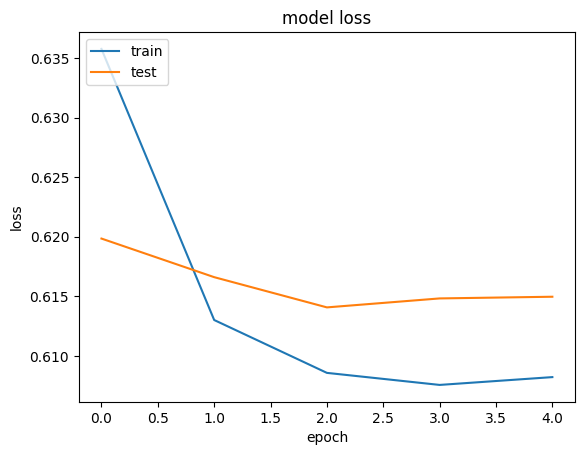

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### 6. User에게 상위 10개의 영화 추천 보여주기

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0] # 유저 1명 추출
movies_watched_by_user = df[df.userId == user_id] # userId가 추출한 userId와 같은 행만 추출
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"] # movie_df에서 movies_watched_by_user의 movieId 열에 있는 value가 아닌 것만 추출
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
) # movies_not_watched와 movie2movie_encoded의 key(즉, movieId)의 교집합을 리스트로 저장
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched] # 안 본 영화의 movieId를 인코딩
user_encoder = user2user_encoded.get(user_id)  # 추출한 유저의 userId를 인코딩
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
) # horizontal, 가로로 행렬 결합
# movies_not_watched는 ()행 1열이므로, 합치면 ()행 2열이 된다.
ratings = model.predict(user_movie_array).flatten() # 원래는 ()행 1열인데, flatten을 하면 1차원이 된다.
top_ratings_indices = ratings.argsort()[-10:][::-1] # argsort를 하면 정렬하기 위한 인덱스 번호가 출력되는데
# 맨 뒤 10개를 추출해서 역순으로 돌린 것이다. 그러면 상위 10위 rating에 해당하는 인덱스만 뽑아오게 된다.
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
] # 2차원 배열이므로 이렇게 한다. 인코딩 값으로 원래 movieId를 얻어낸다.

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("——" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False) # 내림차순
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("——" * 8)
print("Top 10 movie recommendations")
print("——" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Showing recommendations for user: 509
Movies with high ratings from user
————————————————
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
Lord of the Rings: The Two Towers, The (2002) : Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
North & South (2004) : Drama|Romance
Pitch Perfect 2 (2015) : Comedy
————————————————
Top 10 movie recommendations
————————————————
Spanking the Monkey (1994) : Comedy|Drama
Celluloid Closet, The (1995) : Documentary
Candyman: Farewell to the Flesh (1995) : Fantasy|Horror
Homeward Bound II: Lost in San Francisco (1996) : Adventure|Children
Find Me Guilty (2006) : Comedy|Crime|Drama
Hannah Montana: The Movie (2009) : Comedy|Drama|Musical|Romance
Jack and Jill (2011) : Comedy
Garden of Words, The (Koto no ha no niwa) (2013) : Animation|Romance
Into the Forest (2015) : Drama|Sci-Fi
The Editor (2015) : Comedy|Horror|Mystery


In [ ]:
user_movie_array #(9076, 2) -> 총 9724

array([[ 488,    0],
       [ 488, 5804],
       [ 488,    1],
       ...,
       [ 488, 3870],
       [ 488, 2989],
       [ 488, 7869]])

In [ ]:
user_movie_array[:,1].shape

(9076,)

In [ ]:
pred = model.predict(user_movie_array)
print(pred)
print(pred.flatten())

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[0.56666154]
 [0.4964278 ]
 [0.4380166 ]
 ...
 [0.43835035]
 [0.4559531 ]
 [0.42146307]]
[0.56666154 0.4964278  0.4380166  ... 0.43835035 0.4559531  0.42146307]


In [ ]:
user_movie_array.shape

(9076, 2)

In [ ]:
pred.shape

(9076, 1)

In [ ]:
ratings

array([0.56666154, 0.4964278 , 0.4380166 , ..., 0.43835035, 0.4559531 ,
       0.42146307], dtype=float32)

In [71]:
ratings.shape

(9257,)

In [72]:
model.predict(user_movie_array).shape

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


(9257, 1)

In [ ]:
x_train.shape

(90752, 2)

In [ ]:
x_val.shape

(10084, 2)

In [ ]:
y_train.shape

(90752,)

In [ ]:
y_val.shape

(10084,)

In [74]:
a = [[[1,2], [3, 4]], [[5, 6], [7, 8]]]
b = [[[1,2], [3, 4]], [[5, 6], [7, 8]]]

print(ops.tensordot(a, b, axes=2))

tf.Tensor(
[[ 50  60]
 [114 140]], shape=(2, 2), dtype=int32)


In [83]:
a = np.random.randint(1, 10, 19200).reshape(64, 2, 3, 50)
b = np.random.randint(1, 10, 19200).reshape(3, 50, 64, 2)

print(ops.tensordot(a, b, axes=2).shape)


(64, 2, 64, 2)
